In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=25

In [3]:
#loading images from dataset folder
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets",
    shuffle=True,
    seed = 123,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [5]:
#68 batches of 32
len(dataset)

141

In [6]:
#showing shape and labels of the 3 diff classes
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 0 2 1 2 2 2 2 1 1 2 1 1 1 0 1 1 0 0 1 0 1 1 2 0 1 1 1]


In [7]:
#image as array
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy)

<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[204., 203., 208.],
        [200., 199., 204.],
        [196., 195., 200.],
        ...,
        [154., 149., 155.],
        [152., 147., 153.],
        [148., 143., 149.]],

       [[205., 204., 209.],
        [202., 201., 206.],
        [199., 198., 203.],
        ...,
        [163., 158., 164.],
        [160., 155., 161.],
        [156., 151., 157.]],

       [[206., 205., 210.],
        [203., 202., 207.],
        [201., 200., 205.],
        ...,
        [148., 143., 149.],
        [145., 140., 146.],
        [142., 137., 143.]],

       ...,

       [[206., 205., 201.],
        [206., 205., 201.],
        [205., 204., 200.],
        ...,
        [151., 146., 143.],
        [146., 141., 138.],
        [141., 136., 133.]],

       [[206., 205., 201.],
        [205., 204., 200.],
        [204., 203., 199.],
        ...,
        [151., 146., 143.],
        [141., 136., 133.],
       

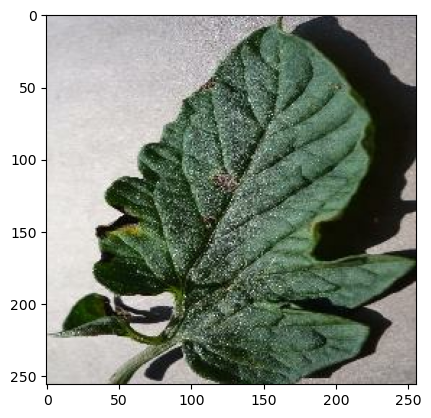

In [8]:
#visualize dataset
plt.imshow(image_batch[0].numpy().astype("uint8"))

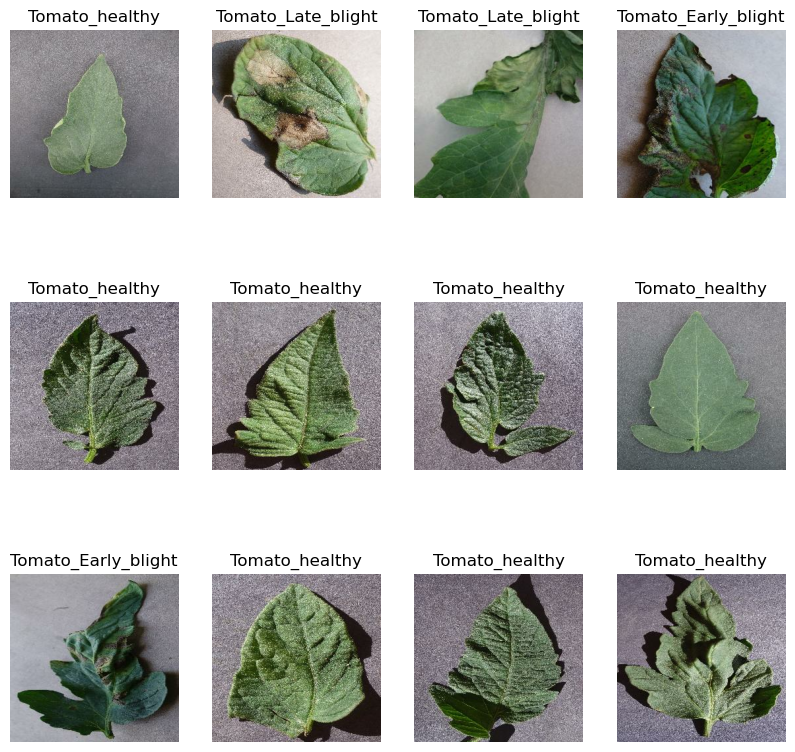

In [9]:
#display a few images
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
#function to split data
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

112

In [13]:
len(test_ds)

15

In [14]:
len(val_ds)

14

In [15]:
#optimize performance using cache and prefetch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [16]:
#cleaning by scale and size image to standard
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
#flipping and rotating images to produce duplicates to train model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
#building model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), #conv layer
    layers.MaxPooling2D((2, 2)), #pooling layer
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(), #flatten after final pooling
    layers.Dense(64, activation='relu'), #hidden layer
    layers.Dense(n_classes, activation='softmax'), #3 neurons same as CHANNELS
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:
#compile model using adam opt

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=25,
)

Epoch 1/25
112/112 - 529s - loss: 0.7600 - accuracy: 0.6475 - val_loss: 0.5398 - val_accuracy: 0.7634 - 529s/epoch - 5s/step
Epoch 2/25
112/112 - 379s - loss: 0.4727 - accuracy: 0.8066 - val_loss: 0.5287 - val_accuracy: 0.7902 - 379s/epoch - 3s/step
Epoch 3/25
112/112 - 369s - loss: 0.3375 - accuracy: 0.8561 - val_loss: 0.4014 - val_accuracy: 0.8326 - 369s/epoch - 3s/step
Epoch 4/25
112/112 - 382s - loss: 0.3044 - accuracy: 0.8723 - val_loss: 1.1034 - val_accuracy: 0.6786 - 382s/epoch - 3s/step
Epoch 5/25
112/112 - 383s - loss: 0.3580 - accuracy: 0.8550 - val_loss: 0.3050 - val_accuracy: 0.8750 - 383s/epoch - 3s/step
Epoch 6/25
112/112 - 384s - loss: 0.2838 - accuracy: 0.8875 - val_loss: 0.2681 - val_accuracy: 0.9040 - 384s/epoch - 3s/step
Epoch 7/25
112/112 - 383s - loss: 0.2628 - accuracy: 0.8917 - val_loss: 0.4801 - val_accuracy: 0.8326 - 383s/epoch - 3s/step
Epoch 8/25
112/112 - 382s - loss: 0.2554 - accuracy: 0.8959 - val_loss: 0.2215 - val_accuracy: 0.9219 - 382s/epoch - 3s/step


In [23]:
scores = model.evaluate(test_ds)
scores

15/15 [==============================] - 88s 827ms/step - loss: 0.1111 - accuracy: 0.9583


[0.1110512763261795, 0.9583333134651184]

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:

len(history.history['loss'])

25

In [26]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.7599940896034241,
 0.47268831729888916,
 0.3375050127506256,
 0.3044131398200989,
 0.3579525053501129]

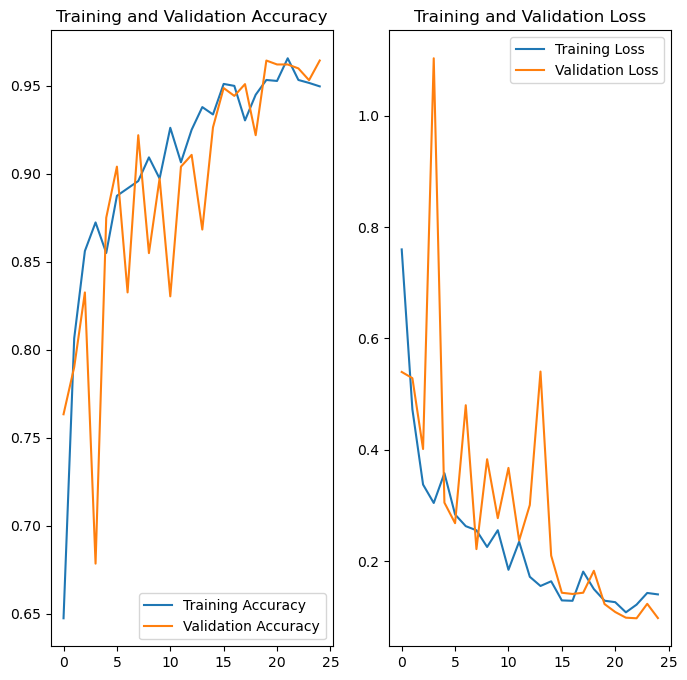

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(25), acc, label='Training Accuracy')
plt.plot(range(25), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(25), loss, label='Training Loss')
plt.plot(range(25), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 4s 4s/step
predicted label: Tomato_healthy


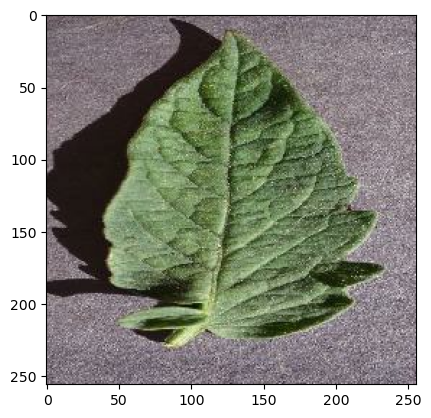

In [28]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
#function for prediction, returns results and confidence level
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 50ms/step


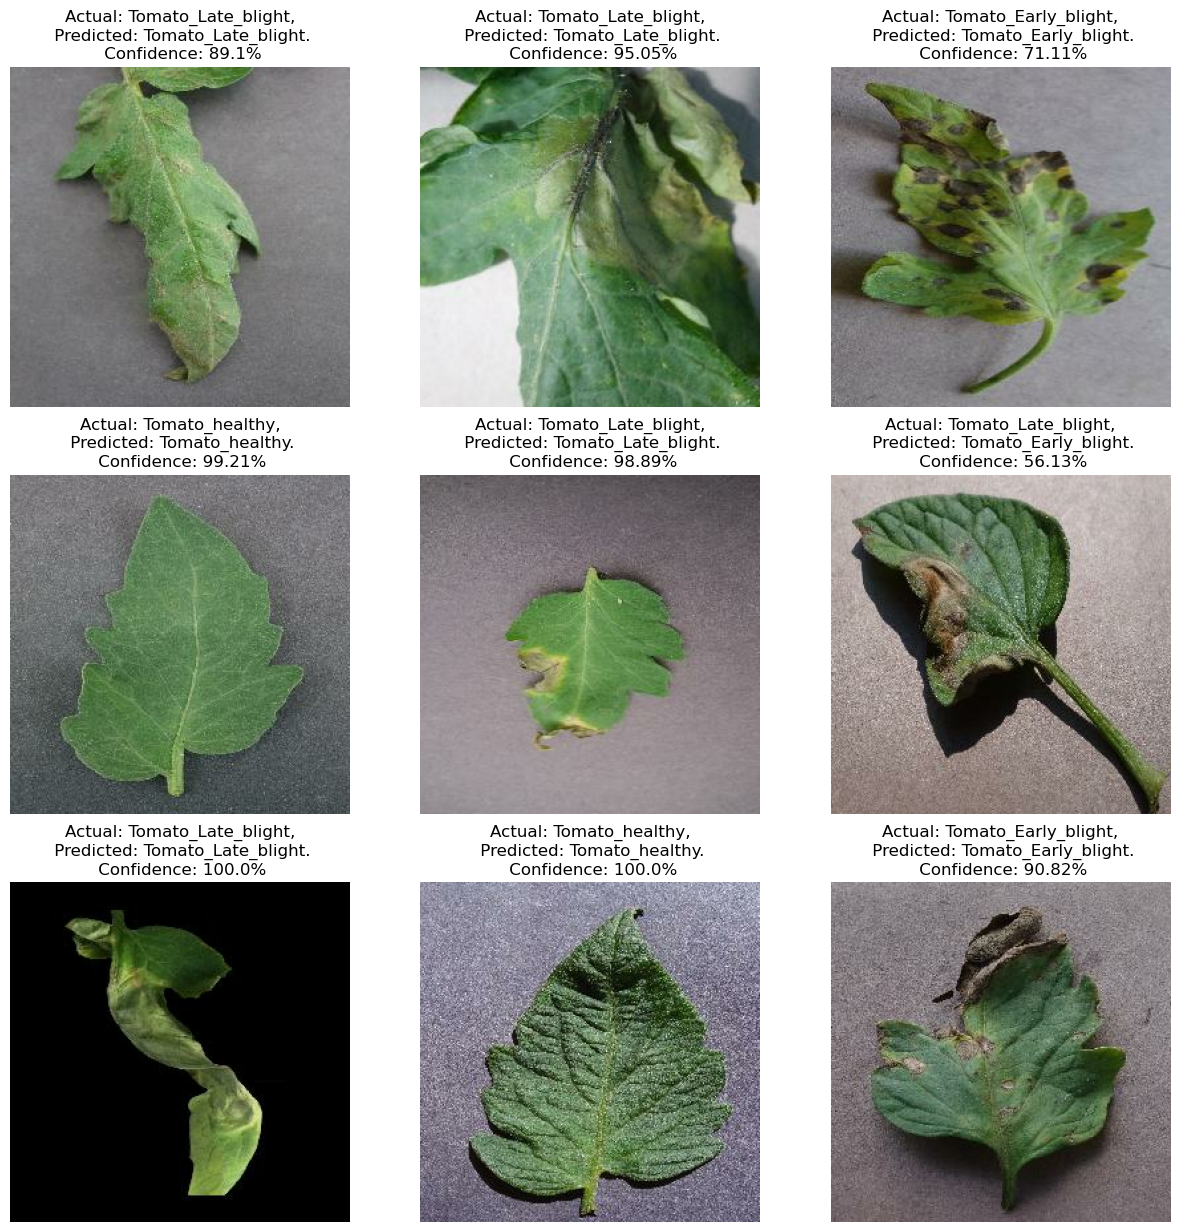

In [30]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [31]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/4\assets


INFO:tensorflow:Assets written to: ../models/4\assets


In [32]:
model.save("../tomatoes.h5")

C:\Users\balm\anaconda\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
